In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import NonUniformImage
import matplotlib.image as img
import seaborn as sns
import scipy.stats as ss
import scipy
from scipy.stats import entropy as scipy_entropy
from PIL import Image
%matplotlib inline
plt.style.use('seaborn')

In [2]:
def jointTable(x, y):
    ones = np.ones((len(x)+1, len(y)+1))
    unique, counts = np.unique(x, return_counts=True)
    xdic = dict(zip(unique, counts))
    unique, counts = np.unique(y, return_counts=True)
    ydic = dict(zip(unique, counts))
    
    for i in range(len(x)+1):
        for j in range(len(y)+1):
            if (i+1 in xdic.keys() and j+1 in ydic.keys()):
                ones[j][i] = (xdic[i+1]/len(x)) * (ydic[i+1]/len(y))
            else:
                ones[j][i] = 0
    df = pd.DataFrame(ones)
    df['Marginal'] = df.sum(axis=1)
    df = df.T
    df['Marginal'] = df.sum(axis=1)
    df = df.T
    return df
df = jointTable([1,1,2,3,4,5,7,7], [1,1,2,3,4,5,7,1])

### Image Prep Functions

In [3]:
def splitImage(img):
    split_img = Image.Image.split(img)
    return split_img[0], split_img[1], split_img[2]

def cropImage(img):
    r, g, b = splitImage(img)
    w, h = img.size
    top = r.crop((20, 0, w-20, h))
    return top, [g.crop((40-x, 0, w-x, h)) for x in range(40, -1, -1)]

### Entropy Function

In [11]:
# This function makes use of scipys entropy function
# Used as a benchmark
def shannon_entropy(image, base=2):
    _, counts = np.unique(image, return_counts=True)
    return scipy_entropy(counts, base=base)

def entropyCalc(X):
    uniq = set(X)
    P = [np.mean(X == x) for x in uniq]
    return sum(-p * np.log2(p) for p in P)

### Functions for getting plot values

In [5]:
def mutualInfoCalc(img, num_bins):
    top, bottoms = cropImage(img)
    mis = []
    for i in range(len(bottoms)):
        hist = np.histogram2d(np.asarray(top).flatten(), np.asarray(bottoms[i]).flatten(), bins=num_bins)
        hist_img = Image.fromarray(hist[0], 'RGB')
        mis.append(entropyCalc(np.asarray(top).flatten()) + entropyCalc(np.asarray(bottoms[i]).flatten()) - entropyCalc(np.asarray(hist_img).flatten()))
    return mis

def binSizeChange(img):
    top, bottoms = cropImage(img)
    mis = []
    for i in range(1, 256):
        hist = np.histogram2d(np.asarray(top).flatten(), np.asarray(bottoms[20]).flatten(), bins=int(256/i))
        hist_img = Image.fromarray(hist[0], 'RGB')
        mis.append(entropyCalc(np.asarray(top).flatten()) + entropyCalc(np.asarray(bottoms[20]).flatten()) - entropyCalc(np.asarray(hist_img).flatten()))
    return mis

### Experiments

In [15]:
flower = Image.open("../input/flower.png")
puffin = Image.open("../input/puffin.jpg")

#### Flower (256*256)

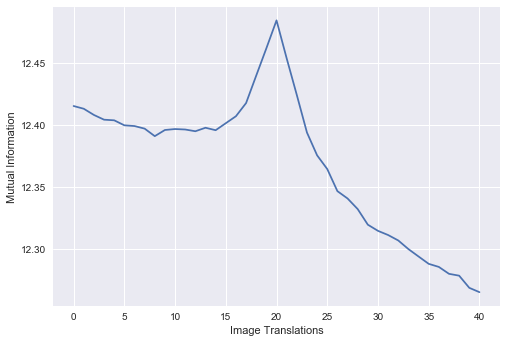

In [13]:
fig = plt.figure()
plt.ylabel('Mutual Information')
plt.xlabel('Image Translations')
sns.lineplot([x for x in range(41)], mutualInfoCalc(flower, 256))

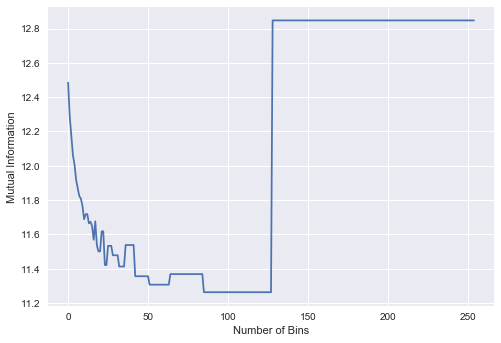

In [14]:
fig = plt.figure()
plt.ylabel('Mutual Information')
plt.xlabel('Number of Bins')
sns.lineplot([x for x in range(255)], binSizeChange(flower))

#### Puffin (800*800)

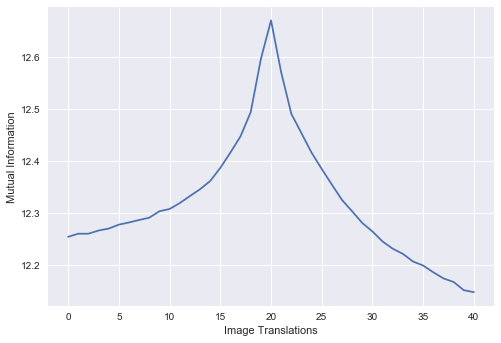

In [16]:
fig = plt.figure()
plt.ylabel('Mutual Information')
plt.xlabel('Image Translations')
sns.lineplot([x for x in range(41)], mutualInfoCalc(puffin, 256))

In [ ]:
fig = plt.figure()
plt.ylabel('Mutual Information')
plt.xlabel('Number of Bins')
sns.lineplot([x for x in range(255)], binSizeChange(puffin))

In [9]:
# hist = np.histogram2d(np.asarray(r).flatten(), np.asarray(g).flatten(), bins=256)
# img = Image.fromarray(hist[0], 'RGB')
# test = shannon_entropy(r) + shannon_entropy(g) - shannon_entropy(img)
# test

### Other Entropy Option

In [10]:
def entropyDep(signal):
    len_sig = signal.size
    sym_set = list(set(signal))
    num_sym = len(sym_set)
    prob = [np.size(signal[signal==i])/(1.0*len_sig) for i in sym_set]
    ent = np.sum([p * np.log2(1.0/p) for p in prob])
    return ent

def getEntropy(binsize, img):
    N = binsize
    S = g.shape
    E = np.array(img)
    for row in range(S[0]):
        for col in range(S[1]):
            Lx=np.max([0,col-N])
            Ux=np.min([S[1],col+N])
            Ly=np.max([0,row-N])
            Uy=np.min([S[0],row+N])
            region=g[Ly:Uy,Lx:Ux].flatten()
            E[row,col]=entropyDep(region)
    return E